In [1]:
from typing import *
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from joblib import Parallel, delayed
import scipy as scp
from tqdm import tqdm

plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)
plt.rc("xtick", top=True, direction="in")
plt.rc("ytick", right=True, direction="in")

In [29]:
def generate_k_regular_graph(k: int, size: int) -> nx.Graph:
    """
    Generate a random 3-regular graph with n nodes.

    Args:
        k (int): The regularity param - number of edges connected to each node.
        size (int): Number of nodes in the graph. Must be an even number.

    Returns:
        nx.Graph: A NetworkX Graph object representing the 3-regular graph.

    Raises:
        ValueError: If the number of nodes is not even.
    """

    G = nx.random_regular_graph(d=k, n=size)
    return G

def draw_graph(G: nx.Graph, show_weights: bool = False) -> None:
    """
    Draw the given graph using a spring layout.

    Args:
        G (nx.Graph): A NetworkX Graph object to be drawn.
        show_weights (bool, optional): Whether to display edge weights or not. Defaults to False.

    Returns:
        None
    """
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
    if show_weights:
        edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

def generate_random_graph(nodes: int,
                          weighted: bool = False,
                          w_min: float = 1e-3) -> List[Tuple[int, int, float]]:
    """
    Generates randomly connected graph of size 'nodes' possibly with random weights in (w_min;1].
    N.B. defaults to all weights = 1.0.

    :param nodes: nr of nodes in graph.
    :param weighted: boolean for having weighted or unweighted edges in graph.
    :param w_min: tolerance for lowest allowable weight in edge.
    :param seed: rng seed for numpy to give reproducibility.
    :return: list of [(head, tail, weight), ...]
    """
    edge_list = []
    avg_nr_edges = int(np.floor((nodes - 1) / 2 + 1))
    for node in range(nodes):
        N_edges = np.random.poisson(lam=avg_nr_edges, size=1)
        while N_edges == 0:  # To avoid node with no connections
            N_edges = np.random.poisson(lam=avg_nr_edges, size=1)
        head = node

        # Doing this to avoid producing multiple weights for same edge in edge_list, i.e. to avoid
        # instances of e.g. [... , (0,1,2.13) , (1,0,0.6) , ... ]
        if len(edge_list) > 0:
            _EDGES = [a.astype(int).tolist() for a in np.array(edge_list)[:, [0, 1]]]
            available_tails = [i for i in range(nodes) if
                               i != head and not ([head, i] in _EDGES or [i, head] in _EDGES)]
        else:
            available_tails = [i for i in range(nodes) if i != head]

        tails = np.random.choice(a=available_tails, replace=False, size=min(N_edges, len(available_tails)))
        for tail in tails:
            weight = np.random.uniform(low=w_min, high=1.0) if weighted else 1.0
            edge_list.append((head, tail, np.round(weight, 4)))
    return edge_list

def get_random_degree_bounds(number: int, min_degree: int = 1, max_degree: int = 10) -> np.ndarray:
    """
    Generate an array of `number` random integers within the range of `min_degree` to `max_degree`.

    Args:
        number (int): The number of random integers to generate.
        min_degree (int, optional): The minimum possible degree value. Defaults to 1.
        max_degree (int, optional): The maximum possible degree value. Defaults to 10.

    Returns:
        np.ndarray: An array of `number` random integers within the range of `min_degree` to `max_degree`.
    """
    return np.random.randint(low=min_degree, high=max_degree+1, size=number)

def get_degree_constrained_subgraph(super_graph: nx.Graph, degree:int, probability: float) -> nx.Graph:
    """
    Constructs a degree-constrained subgraph from a given 3-regular graph using a randomized edge selection process.

    Parameters
    ----------
    super_graph : networkx.Graph
        The input 3-regular graph from which to construct the degree-constrained subgraph.
    degree : int
        The maximum degree constraint for nodes in the resulting subgraph.
    probability : float
        The probability of temporarily including each edge in the subgraph.

    Returns
    -------
    networkx.Graph
        The degree-constrained subgraph with the maximum degree of nodes equal to the specified 'degree'.
    """
    _node_degree_counter = np.zeros(shape=(super_graph.number_of_nodes()))
    _sub_graph_edges = []

    # Temporarily include each edge with probability p
    for edge in list(super_graph.edges):
        if np.random.binomial(n=1, p=probability) == 1:
            node_i, node_j = edge
            _node_degree_counter[node_i] += 1
            _node_degree_counter[node_j] += 1
            _sub_graph_edges.append(edge)

    # Discard edges that violate the degree constraint
    _updated_sub_graph_edges = []
    for sub_edge in _sub_graph_edges:
        sub_node_i, sub_node_j = sub_edge
        if _node_degree_counter[sub_node_i] <= degree and _node_degree_counter[sub_node_j] <= degree:
            _updated_sub_graph_edges.append(sub_edge)

    _sub_graph_edges = _updated_sub_graph_edges
    _subgraph = nx.Graph()
    _subgraph.add_edges_from(_sub_graph_edges)
    return _subgraph

def get_variable_degree_constrained_subgraph(super_graph_edge_list: List[Tuple], nr_nodes: int, degree_constraints: List[int], probabilities: List[float]) -> nx.Graph:
    """
    Constructs a degree-constrained subgraph from a given graph using a randomized edge selection process.

    Parameters
    ----------
    super_graph : networkx.Graph
        The input graph from which to construct the degree-constrained subgraph.
    degree_constraints : List[int]
        A list of maximum degree constraints for each node in the resulting subgraph.
    probabilities : List[float]
        The probabilities of temporarily including each edge in the subgraph.

    Returns
    -------
    networkx.Graph
        The degree-constrained subgraph with the maximum degree of nodes equal to the specified degree constraints.
    """
    _node_degree_counter = np.zeros(shape=(nr_nodes,))
    _sub_graph_edges = []

    # Temporarily include each edge with probability p
    for idx, edge in enumerate(super_graph_edge_list):
        if np.random.binomial(n=1, p=probabilities[idx]) == 1:
            node_i, node_j, w = edge
            _node_degree_counter[node_i] += 1
            _node_degree_counter[node_j] += 1
            _sub_graph_edges.append(edge)

    # Discard edges that violate the degree constraint
    _updated_sub_graph_edges = []
    for sub_edge in _sub_graph_edges:
        sub_node_i, sub_node_j, w = sub_edge
        if _node_degree_counter[sub_node_i] <= degree_constraints[sub_node_i] and _node_degree_counter[sub_node_j] <= degree_constraints[sub_node_j]:
            _updated_sub_graph_edges.append(sub_edge)
    return _updated_sub_graph_edges

def avg_relative_subgraph_sizes(probabilities: Union[List[float],np.ndarray[float]], trials: int, min_graph_size: int, max_graph_size: int) -> List[float]:
    """
    Compute the average relative size of degree-constrained subgraphs for a range of graph sizes and edge inclusion probabilities.

    Parameters
    ----------
    probabilities : list of float
        The edge inclusion probabilities to be tested.
    trials : int
        The number of trials for each combination of graph size and edge inclusion probability.
    min_graph_size : int
        The minimum graph size (number of nodes) to be tested.
    max_graph_size : int
        The maximum graph size (number of nodes) to be tested.

    Returns
    -------
    list of float
        The average relative size of the degree-constrained subgraphs for each edge inclusion probability.

    Notes
    -----
    This function computes the average relative size of degree-constrained subgraphs for each edge inclusion probability
    by generating 3-regular graphs of varying sizes, constructing subgraphs using the provided probabilities, and then
    computing the relative size (number of edges in subgraph / number of edges in supergraph) for each subgraph.
    The function returns a list containing the average relative size for each tested probability.
    """
    _graph_sizes = np.arange(min_graph_size,max_graph_size,2)
    _avg_subgraph_sizes = []
    for i in range(len(probabilities)):
        _prob = probabilities[i]
        _temp = []
        for _graph_size in _graph_sizes:
            avg_nr_subgraph_edges_relative = 0
            for _trial in range(trials):
                _supergraph = generate_k_regular_graph(k=3, size=_graph_size)
                _subgraph   = get_degree_constrained_subgraph(super_graph=_supergraph,degree=2,probability=_prob)
                avg_nr_subgraph_edges_relative += _subgraph.number_of_edges() * 1.0/_supergraph.number_of_edges()
            avg_nr_subgraph_edges_relative *= 1.0/_trials
            _temp.append(avg_nr_subgraph_edges_relative)
        _avg_subgraph_sizes.append(np.mean(_temp))
    return _avg_subgraph_sizes

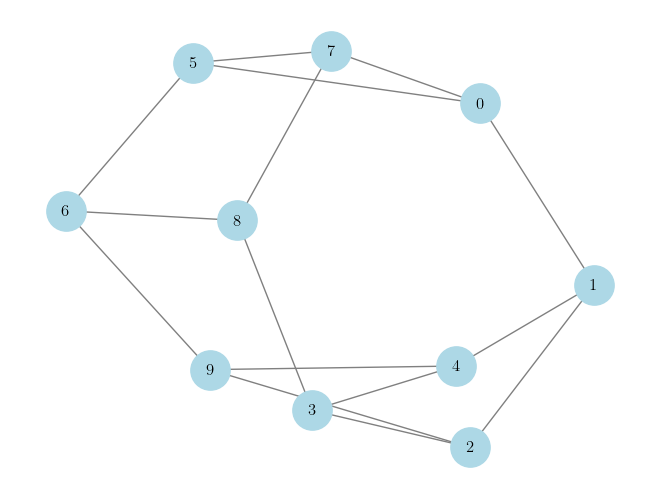

In [3]:
graph = generate_k_regular_graph(k=3, size=10)
draw_graph(graph)

# Considering exercise 1:

In [73]:
num_cores = multiprocessing.cpu_count()
print("Number of available CPU cores: ", num_cores)

Number of available CPU cores:  8


In [74]:
_pmin, _pmax = 0.001,0.999
_n_probs = 1000
_probabilities = np.linspace(_pmin,_pmax,_n_probs)

_trials = 400
_min_graph_size, _max_graph_size = 4, 50

########################################################################################
######## Partitioning into even sized intervals -> One interval pr. core in CPU ########
########################################################################################
# Calculate the range_size that is a multiple of num_cores
_N_max = _n_probs
range_size = ((_N_max-1) // num_cores) * num_cores
# Adjust N_max value
N_max_adjusted = 1 + range_size
# Calculate interval size
Interval_size = int((N_max_adjusted - 1) / num_cores)
# Calculate partitions
partitions = [_probabilities[Interval_size * i: Interval_size * (i+1)] for i in range(num_cores)]
print(f"Adjusted N_max from {_N_max} to {N_max_adjusted} and now have {num_cores} evenly sized intervals of size {Interval_size}.")


Adjusted N_max from 1000 to 993 and now have 8 evenly sized intervals of size 124.


In [75]:
backend = 'loky'
results = Parallel(n_jobs=num_cores, backend=backend)(delayed(avg_relative_subgraph_sizes)(partition,_trials,_min_graph_size,_max_graph_size) for partition in partitions)

In [76]:
avg_relative_sizes = []
for result in results:
    avg_relative_sizes += result
probabilities = []
for probability in partitions:
    probabilities += probability.tolist()

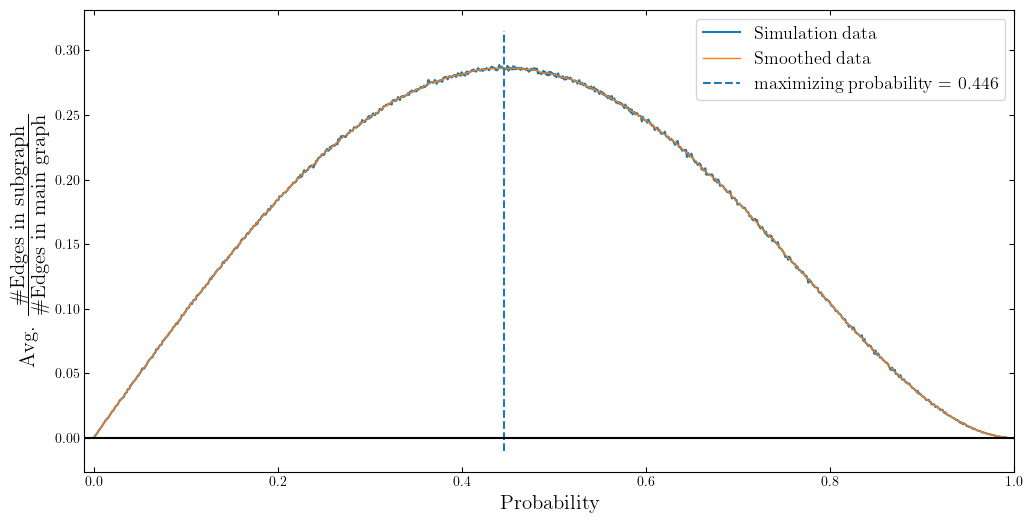

In [88]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.plot(probabilities,avg_relative_sizes, label="Simulation data")

smooth_y = scp.signal.savgol_filter(x=avg_relative_sizes,window_length=19,polyorder=3)
ax.plot(probabilities,smooth_y, lw=1, label="Smoothed data")

max_prop = probabilities[np.argmax(smooth_y)]
ax.vlines(max_prop,-0.01,1.1*np.max(smooth_y),ls='--',label=f'maximizing probability = {np.round(max_prop,3)}')

ax.set_ylabel(r'Avg. $\frac{\textrm{\#Edges in subgraph}}{\textrm{\#Edges in main graph}}$', size=15)
ax.set_xlabel('Probability', size=15)
ax.hlines(0,-0.01,1,color='k')
ax.set_xlim(-0.01,1)
ax.legend(fontsize=13,loc='upper right')
plt.show()

# Considering Exercise 2:

In [109]:
# Construct randomly weighted graph
seed = 2
size = 7
edge_list = generate_random_graph(nodes=size,weighted=True)
test_graph = nx.Graph()
test_graph.add_weighted_edges_from(edge_list)
len(edge_list)

21

In [106]:
node_edge_indicator = [[0 for i in range(len(edge_list))] for j in range(size)]
for row in range(size):
    for col in range(len(edge_list)):
        if edge_list[col][0] == row:
            node_edge_indicator[row][col] = 1
        if edge_list[col][1] == row:
            node_edge_indicator[row][col] = 1
node_edge_indicator

[[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]]

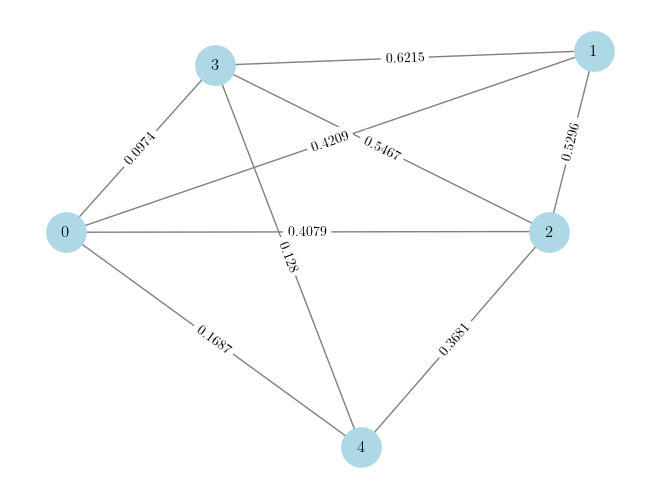

In [49]:
draw_graph(test_graph,show_weights=True)

In [96]:
weights       = [-obj[-1] for obj in edge_list]
degree_bounds = get_random_degree_bounds(number=size,min_degree=1,max_degree=size//2).tolist()
degree_bounds, weights

([2, 1, 2, 1, 1],
 [-0.5925,
  -0.3469,
  -0.2645,
  -0.322,
  -0.3979,
  -0.2782,
  -0.9363,
  -0.2959,
  -0.1881,
  -0.2157])

In [99]:
lims = [(0.0,1.0) for edge in range(len(edge_list))]
res = scp.optimize.linprog(weights, A_ub=node_edge_indicator, b_ub=degree_bounds, bounds=lims,method='highs')
continuous_state = res.x.tolist()
continuous_cost  = res.fun
continuous_cost, continuous_state

(-1.5476999999999999, [-0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, -0.0, 0.0])

In [98]:
# randomize rounding with prob p*x(e)
p = 1
discrete_state = [1 if np.random.binomial(n=1, p=p*x_e) == 1 else 0 for x_e in continuous_state]
discrete_state

[0, 1, 1, 0, 0, 0, 1, 0, 0, 0]

#### Average over many cases:

In [50]:
def generate_bit_string_permutations(n: int) -> np.ndarray:
    """
    A 'generator' type function that calculates all 2^n
    permutations of a 'n-length' bitstring one at a time.
    (All permutations are not stored in memory simultaneously).

    :param n: length of bit-string
    :return: i'th permutation.
    """
    num_permutations = 2 ** n
    for i in range(num_permutations):
        binary_string = bin(i)[2:].zfill(n)
        permutation = np.array([int(x) for x in binary_string])
        yield permutation

def min_cost_partition(nr_edges: int,
                       weights: np.ndarray) -> Tuple[float, np.ndarray]:
    """
    Given nr_nodes (length of bitstring), determines minimal cost
    and corresponding partition.

    :param nr_nodes: nr_nodes in graph - corresponding to length of bitstring
    :param weights: 1d array used for cost
    :return: min_cost, min_perm: minimal cost, corresponding partition
    """
    if nr_edges >= 22:
        raise ValueError("To many edges in problem instance for feasible time sol.")
    min_cost, min_perm = np.inf, np.empty(shape=(nr_edges,))
    for perm in generate_bit_string_permutations(n=nr_edges):
        perm_cost = np.dot(perm,weights)
        if perm_cost < min_cost:
            min_cost, min_perm = perm_cost, perm

    return min_cost, min_perm

def avg_relative_subgraph_total_weights(probabilities: Union[List[float],np.ndarray[float]], trials: int, min_graph_size: int, max_graph_size: int) -> Tuple[List[float], List[float]]:
    """
    Parameters
    ----------
    probabilities : list of float
        The edge inclusion probabilities to be tested.
    trials : int
        The number of trials for each combination of graph size and edge inclusion probability.
    min_graph_size : int
        The minimum graph size (number of nodes) to be tested.
    max_graph_size : int
        The maximum graph size (number of nodes) to be tested.

    Returns
    -------
    list of float
        The average relative ratios.
    """

    _graph_sizes = np.arange(min_graph_size,max_graph_size,1)
    _avg_ratios = []
    for i in tqdm(range(len(probabilities))):
        _prob = probabilities[i]
        _temp = []
        for _graph_size in _graph_sizes:
            _avg_ratio = 0.0
            for trial in range(trials):
                # Generate initial randomly weighted graph
                _edge_list = generate_random_graph(nodes=_graph_size,weighted=True)
                _super_graph = nx.Graph()
                _super_graph.add_weighted_edges_from(_edge_list)
                # Generate matrix for LP constraint
                _node_edge_indicator = [[0 for i in range(len(_edge_list))] for j in range(_graph_size)]
                for _row in range(_graph_size):
                    for _col in range(len(_edge_list)):
                        i,j,w =_edge_list[_col]
                        if i == _row or j == _row:
                            _node_edge_indicator[_row][_col] = 1
                # Define weights from graph and generate random degree constraints
                _weights       = [-obj[-1] for obj in _edge_list]
                _degree_bounds = get_random_degree_bounds(number=_graph_size,min_degree=1,max_degree=_graph_size//2).tolist()
                # Solved continuous LP using scipy
                _lims = [(0.0,1.0) for _edge in range(len(_edge_list))]
                _avg_lower_bounds    = np.zeros(shape=(len(_edge_list)))
                _avg_inclusion_probs = np.zeros(shape=(len(_edge_list)))
                _res = scp.optimize.linprog(_weights, A_ub=_node_edge_indicator, b_ub=_degree_bounds, bounds=_lims,method='highs')
                _continuous_state = _res.x
                _continuous_val   = _res.fun
                # Getting subgraph
                _inclusion_probs  = [x_e*_prob for x_e in _continuous_state]
                _final_sub_graph  = get_variable_degree_constrained_subgraph(super_graph_edge_list=_edge_list,
                                                                             nr_nodes=_graph_size,
                                                                             degree_constraints=_degree_bounds,probabilities=_inclusion_probs)
                _final_sub_graph_bitstring = np.zeros(shape=(len(_edge_list),))
                for idx, _e in enumerate(_edge_list):
                    if _e in _final_sub_graph:
                        _final_sub_graph_bitstring[idx] = 1
                # Calculating ratio
                _ratio = np.dot(_final_sub_graph_bitstring,np.array(_weights))/_continuous_val
                _avg_ratio += _ratio

            _temp.append(_avg_ratio/trials)
        _avg_ratios.append(np.mean(_temp))
    return _avg_ratios



In [51]:
_edge_list = generate_random_graph(nodes=4,weighted=True)
_super_graph = nx.Graph()
_super_graph.add_weighted_edges_from(_edge_list)

In [52]:
num_cores = multiprocessing.cpu_count()
print("Number of available CPU cores: ", num_cores)

Number of available CPU cores:  8


In [53]:
_pmin, _pmax = 0.001,0.999
_n_probs = 1000
_probabilities = np.linspace(_pmin,_pmax,_n_probs)

_trials = 50
_min_graph_size, _max_graph_size = 3, 10

########################################################################################
######## Partitioning into even sized intervals -> One interval pr. core in CPU ########
########################################################################################
# Calculate the range_size that is a multiple of num_cores
_N_max = _n_probs
range_size = ((_N_max-1) // num_cores) * num_cores
# Adjust N_max value
N_max_adjusted = 1 + range_size
# Calculate interval size
Interval_size = int((N_max_adjusted - 1) / num_cores)
# Calculate partitions
partitions = [_probabilities[Interval_size * i: Interval_size * (i+1)] for i in range(num_cores)]
print(f"Adjusted N_max from {_N_max} to {N_max_adjusted} and now have {num_cores} evenly sized intervals of size {Interval_size}.")


Adjusted N_max from 1000 to 993 and now have 8 evenly sized intervals of size 124.


In [54]:
backend = 'loky'
results = Parallel(n_jobs=num_cores, backend=backend)(delayed(avg_relative_subgraph_total_weights)(partition,_trials,_min_graph_size,_max_graph_size) for partition in partitions)

100%|██████████| 124/124 [00:28<00:00,  4.30it/s]


In [46]:
avg_weight_ratios = []
for result in results:
    avg_weight_ratios += result
probabilities = []
for probability in partitions:
    probabilities += probability.tolist()

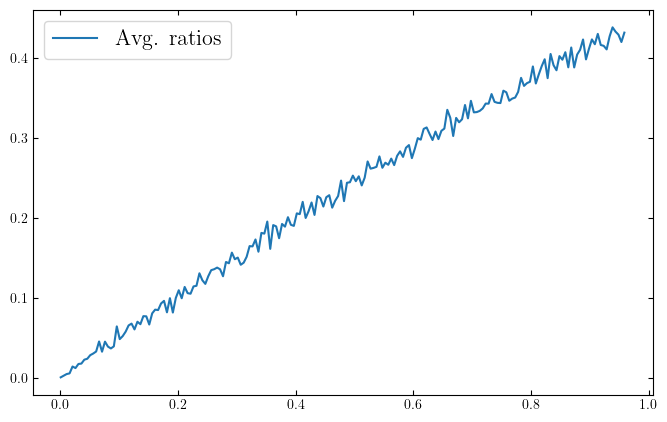

In [47]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(probabilities,avg_weight_ratios, label='Avg. ratios')
ax.legend(fontsize=16)
plt.show()